In [ ]:
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import os.path
from os import path
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def read_covid_data(data_type):
    if (data_type in ['confirmed', 'deaths', 'recovered']):
        COVID_directory = "/Users/kootsoop/git/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
        first_row = None
        with open(COVID_directory + 'time_series_covid19_' + data_type + '_global.csv') as csvfile:
            confirmed = csv.reader(csvfile)
            for row in confirmed:
                if (first_row == None):
                    first_row = row
                if (row[1] == 'US'):
                    us_data = row
                    break
    else:
        raise Exception('Invalid data_type', data_type)
    return(first_row, us_data)

FORECAST_FILE = 'forecasts500k.txt'
if (path.exists(FORECAST_FILE)):
    forecast_file = open(FORECAST_FILE, 'r')
    forecasts500k = json.load(forecast_file)
    forecast_file.close()
else:
    forecasts500k = {}

(first_row, confirmed) = read_covid_data('confirmed')
(first_row2, recovered) = read_covid_data('recovered')
(first_row3, deaths) = read_covid_data('deaths')

death_data = [(float(data)) for data in deaths[4:(len(first_row))]]
recovered_data = [(float(data)) for data in recovered[4:(len(first_row))]]
confirmed_data = [(float(data)) for data in confirmed[4:(len(first_row))]]

first_row_shifted = [ data for data in first_row[4:(len(first_row))]]
x_axis = arange(len(death_data))

NumberInEstimateWindow = 20

# Started at 70 @ 2020/5/10
# 133 2020/06/24
# 137 2020/06/28
start_fit = len(death_data) - (NumberInEstimateWindow + 1)
# Started 20 more than start_fit
end_fit = start_fit + NumberInEstimateWindow
y_fit_data = death_data[start_fit:end_fit+1]
x_fit_data = arange(start_fit,end_fit+1)

y_pre = death_data[1:start_fit]
x_pre = arange(1,start_fit)


y_new_data = death_data[end_fit+1:len(death_data)]
x_new_data = arange(end_fit+1, len(death_data))

x_forecast = arange(end_fit, len(death_data) + 20)

[m, b] = polyfit(x_fit_data, y_fit_data, 1)

day_for_500k = (500000-b)/m

day_for_300k = (300000-b)/m


days_until = day_for_500k - len(first_row_shifted) 
days_until_300k = day_for_300k - len(first_row_shifted) 

print('Days until 500k: ' + str(day_for_500k - len(first_row_shifted) ))

plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)


date_for_500k = (datetime.now() + timedelta(days=days_until)).date()
date_for_300k = (datetime.now() + timedelta(days=days_until_300k)).date()

print('300k:' + str(date_for_300k))

if (not first_row_shifted[end_fit] in forecasts500k):
    print("Updating file.")
    forecasts500k.update({ first_row_shifted[end_fit] : str(date_for_500k) })
    forecast_file = open(FORECAST_FILE, 'w+')
    json.dump(forecasts500k, forecast_file)
    forecast_file.close()


dates = []
forecasts = []
for date in forecasts500k:
    forecasts.append(datetime.strptime(forecasts500k[date], '%Y-%m-%d'))
    dates.append(datetime.strptime(date, '%m/%d/%y'))
    
election_date = datetime.strptime('2020-11-03', '%Y-%m-%d')
election_day_of_year = (election_date - datetime(election_date.year, 1, 1)).days + 1

start_data_date = datetime.strptime(first_row_shifted[start_fit], '%m/%d/%y')
deaths_at_election = int(m*(election_day_of_year)+b)
deaths_at_election_end = int(m*(election_day_of_year+1)+b)

end_of_year_date = datetime.strptime('2020-12-31', '%Y-%m-%d')
end_of_year_day = (end_of_year_date - datetime(end_of_year_date.year, 1, 1)).days + 1
deaths_at_end_of_year = int(m*(end_of_year_day)+b)

nine_eleven_date = datetime.strptime('2020-09-11', '%Y-%m-%d')
nine_eleven_day = (nine_eleven_date - datetime(nine_eleven_date.year, 1, 1)).days + 1
deaths_at_nine_eleven_day = int(m*(nine_eleven_day)+b)


print(election_date)
print(start_data_date)
print(first_row_shifted[start_fit])
print(election_day_of_year)
print(deaths_at_election)
print(deaths_at_election_end)
print(deaths_at_end_of_year)
print(deaths_at_nine_eleven_day)
print(deaths_at_nine_eleven_day/2977)

print('Estimated deaths per day: ' + str(m))

plt.figure(1)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot([election_day_of_year, election_day_of_year], [deaths_at_election, deaths_at_election_end],'r+',markersize=20,  label='Deaths at election: ' + str(deaths_at_election))
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_500k, 500000, 'rx', markersize=50, label='500,000 deaths on ' + str(date_for_500k))
plt.ylim(0,300000)
plt.xlim(60,350)
plt.title('Data used in forecast is from ' + first_row_shifted[start_fit] + ' to ' + first_row_shifted[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=30)

plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST-' + first_row_shifted[end_fit].replace('/','-') + '.png')

death_percent = [i / j * 100.0 for i, j in zip(death_data, confirmed_data)] 


plt.figure(2)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(dates, forecasts,'g+', markersize=50)
plt.title('Forecast 500k date over time', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST-HISTORY-' + first_row_shifted[end_fit].replace('/','-') + '.png')
# Doesn't seem to do the right thing: ax.set_xticklabels(dates)

plt.figure(3)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)

death_by_delay = {}

for delay in arange(22):
    death_percent_with_delay = [i / j * 100.0 for i, j in zip(death_data[0:len(death_data)-delay], confirmed_data[delay:len(confirmed_data)])] 
    plt.plot(x_axis[0:len(death_data)-delay], death_percent_with_delay)
    death_by_delay[delay] = death_percent_with_delay[len(death_percent_with_delay)-1]
plt.title('Deaths as a percentage of confirmed cases, max delay:' + str(delay), fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DELAY.png')

plt.figure(4)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
death_list = sorted(death_by_delay.items())
x,y = zip(*death_list)
plt.plot(x, y)
plt.title('Deaths as a percentage of confirmed cases (delay in days vs percentage)', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-ESTIMATE.png')

plt.figure(5)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(x_axis , death_data)
# plt.plot(x_axis, confirmed_data, 'r')
plt.title('Deaths and confirmed numbers.', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DEATHS-AND-CONFIRMED.png')

plt.figure(6)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot([election_day_of_year, election_day_of_year], [deaths_at_election, deaths_at_election_end],'r+',markersize=20,  label='Deaths at election: ' + str(deaths_at_election))
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_500k, 500000, 'rx', markersize=50, label='500,000 deaths on ' + str(date_for_500k))
plt.ylim(125000,210000)
plt.xlim(150,275)
plt.title('Data used in forecast is from ' + first_row_shifted[start_fit] + ' to ' + first_row_shifted[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=30)




Days until 500k: 121.67961531162229
300k:2020-12-17
2020-11-03 00:00:00
2020-11-18 00:00:00
11/18/20
308
262002
263756
363740
169034
56.77997984548203
Estimated deaths per day: 1754.1155844155837


Locator attempting to generate 40580 ticks ([697188.0, ..., 778346.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 40580 ticks ([697188.0, ..., 778346.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 40580 ticks ([697188.0, ..., 778346.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 40580 ticks ([697188.0, ..., 778346.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 81169 ticks ([697306.0, ..., 778474.0]), which exceeds Locator.MAXTICKS (1000).


mean   : 2020-09-26 06:00:00
median : 2020-09-20 00:00:00


<Figure size 432x288 with 0 Axes>

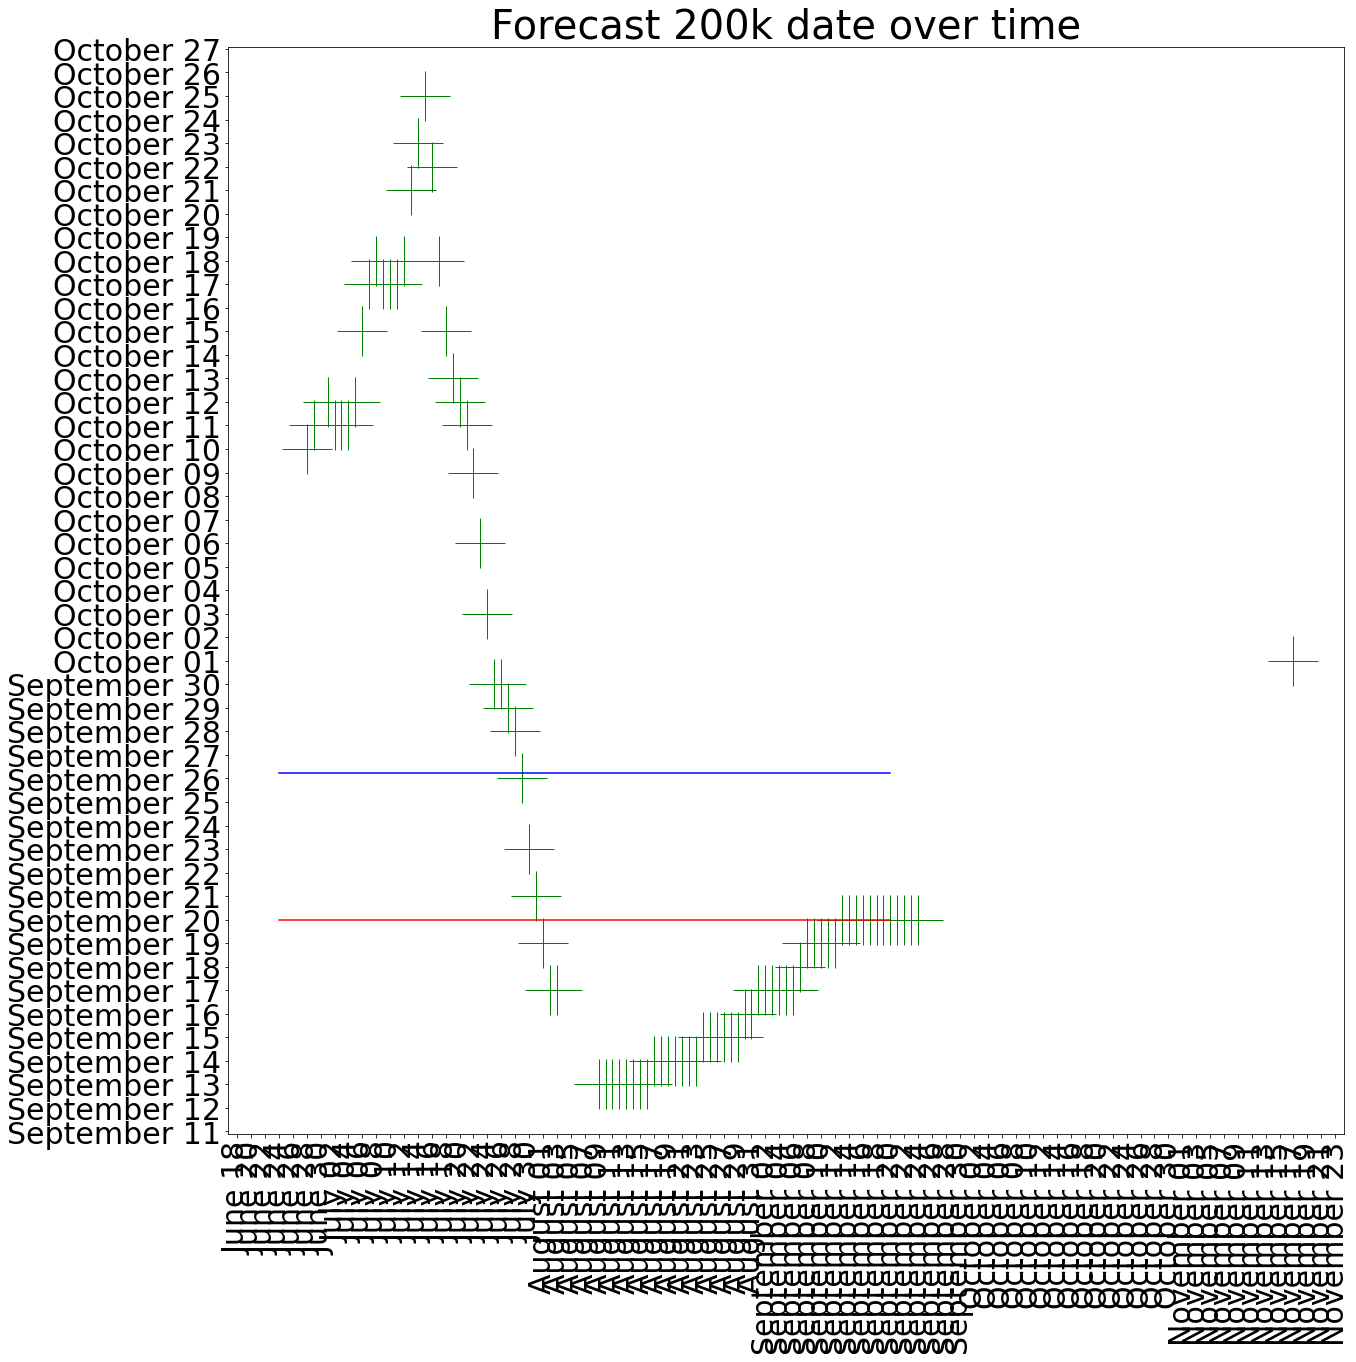

In [3]:
import numpy as np
from scipy import stats

mean_forecast = np.mean([x - min(forecasts) for x in forecasts ]) + min(forecasts)
median_forecast = np.median([x - min(forecasts) for x in forecasts ]) + min(forecasts)
print("mean   : " + str(mean_forecast))
print("median : " + str(median_forecast))
# print("mode.  : " + str(stats.mode([x - min(forecasts) for x in forecasts ]) + min(forecasts)))


start_of_forecasts = datetime.strptime('2020-06-24', '%Y-%m-%d')
end_of_forecasts = datetime.strptime('2020-09-20', '%Y-%m-%d')

plt.figure(0)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(dates, forecasts,'g+', markersize=50)
plt.plot([start_of_forecasts, end_of_forecasts], [median_forecast,median_forecast],'r')
plt.plot([start_of_forecasts, end_of_forecasts], [mean_forecast,mean_forecast],'b')
plt.title('Forecast 500k date over time', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST-HISTORY-FINAL.png')
# Doesn't seem to do the right thing: ax.set_xticklabels(dates)


In [ ]:
plt.figure(0)
plt.figure(figsize=(20,20))
plt.plot(first_row_shifted, death_data)

Days until 500k: 121.67961531162229
300k:2020-12-17
500k:2021-04-10


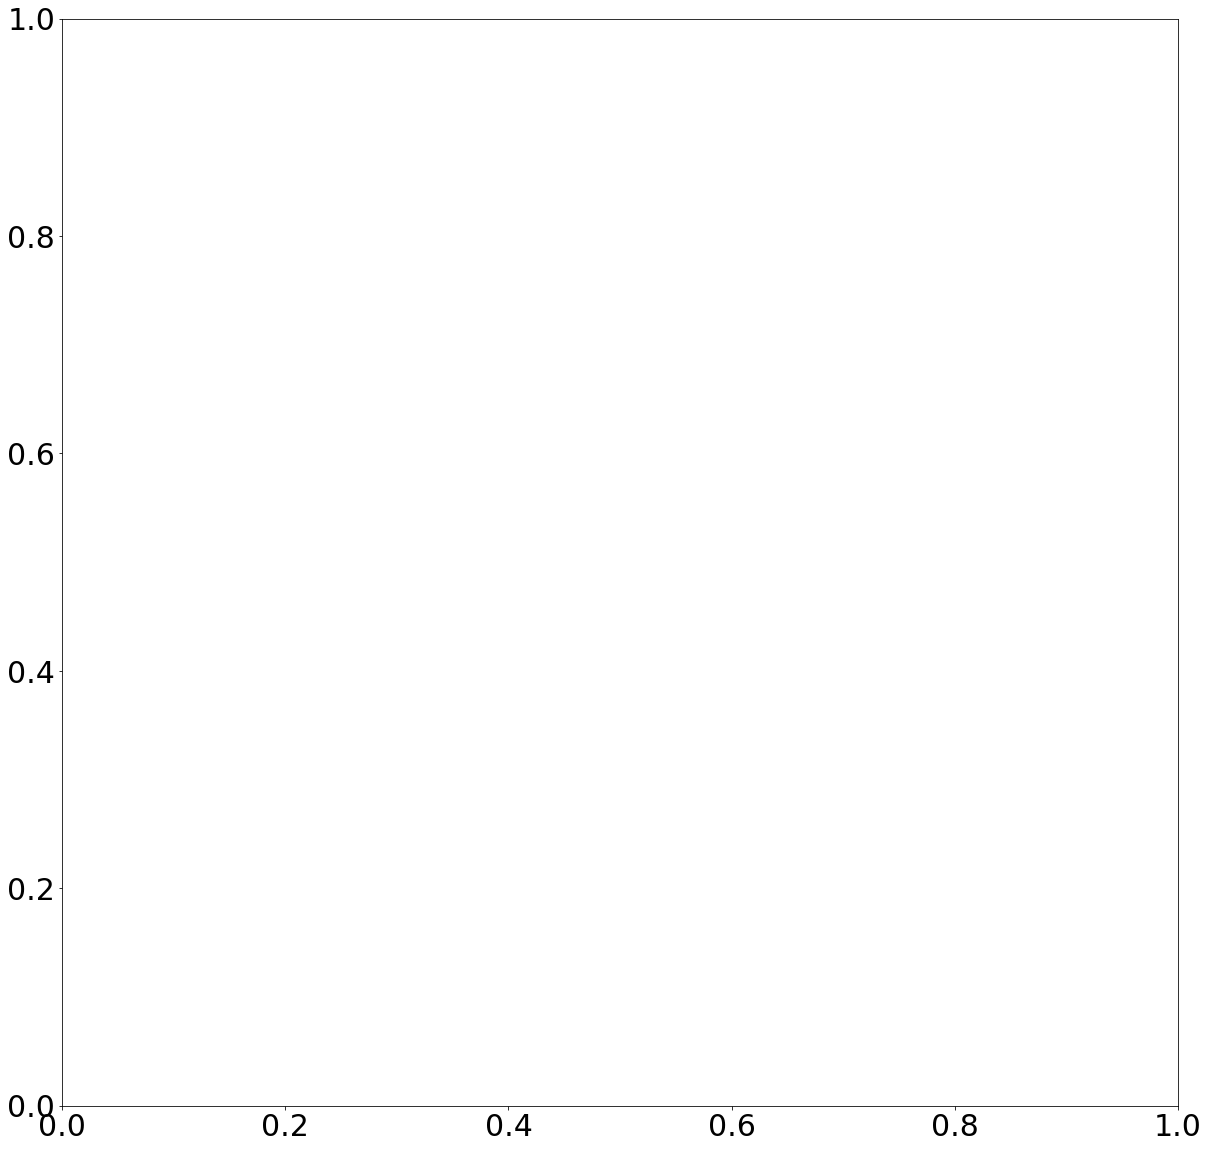

In [6]:
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import os.path
from os import path
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def read_covid_data(data_type):
    if (data_type in ['confirmed', 'deaths', 'recovered']):
        COVID_directory = "/Users/kootsoop/git/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
        first_row = None
        with open(COVID_directory + 'time_series_covid19_' + data_type + '_global.csv') as csvfile:
            confirmed = csv.reader(csvfile)
            for row in confirmed:
                if (first_row == None):
                    first_row = row
                if (row[1] == 'US'):
                    us_data = row
                    break
    else:
        raise Exception('Invalid data_type', data_type)
    return(first_row, us_data)

FORECAST_FILE = 'forecasts500k.txt'
if (path.exists(FORECAST_FILE)):
    forecast_file = open(FORECAST_FILE, 'r')
    forecasts500k = json.load(forecast_file)
    forecast_file.close()
else:
    forecasts500k = {}

(first_row, confirmed) = read_covid_data('confirmed')
(first_row2, recovered) = read_covid_data('recovered')
(first_row3, deaths) = read_covid_data('deaths')


death_data = [(float(data)) for data in deaths[4:(len(first_row))]]
recovered_data = [(float(data)) for data in recovered[4:(len(first_row))]]
confirmed_data = [(float(data)) for data in confirmed[4:(len(first_row))]]


first_row_shifted = [ data for data in first_row[4:(len(first_row))]]
x_axis = arange(len(death_data))

NumberInEstimateWindow = 20

# Started at 70 @ 2020/5/10
# 133 2020/06/24
# 137 2020/06/28
start_fit = len(death_data) - (NumberInEstimateWindow + 1)
# Started 20 more than start_fit
end_fit = start_fit + NumberInEstimateWindow
y_fit_data = death_data[start_fit:end_fit+1]
x_fit_data = arange(start_fit,end_fit+1)

y_pre = death_data[1:start_fit]
x_pre = arange(1,start_fit)


y_new_data = death_data[end_fit+1:len(death_data)]
x_new_data = arange(end_fit+1, len(death_data))

x_forecast = arange(end_fit, len(death_data) + 20)

[m, b] = polyfit(x_fit_data, y_fit_data, 1)

day_for_500k = (500000-b)/m

day_for_300k = (300000-b)/m


days_until = day_for_500k - len(first_row_shifted) 
days_until_300k = day_for_300k - len(first_row_shifted) 

print('Days until 500k: ' + str(day_for_500k - len(first_row_shifted) ))

plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)


date_for_500k = (datetime.now() + timedelta(days=days_until)).date()
date_for_300k = (datetime.now() + timedelta(days=days_until_300k)).date()

print('300k:' + str(date_for_300k))
print('500k:' + str(date_for_500k))


In [3]:
read_covid_data('deaths')

(['Province/State',
  'Country/Region',
  'Lat',
  'Long',
  '1/22/20',
  '1/23/20',
  '1/24/20',
  '1/25/20',
  '1/26/20',
  '1/27/20',
  '1/28/20',
  '1/29/20',
  '1/30/20',
  '1/31/20',
  '2/1/20',
  '2/2/20',
  '2/3/20',
  '2/4/20',
  '2/5/20',
  '2/6/20',
  '2/7/20',
  '2/8/20',
  '2/9/20',
  '2/10/20',
  '2/11/20',
  '2/12/20',
  '2/13/20',
  '2/14/20',
  '2/15/20',
  '2/16/20',
  '2/17/20',
  '2/18/20',
  '2/19/20',
  '2/20/20',
  '2/21/20',
  '2/22/20',
  '2/23/20',
  '2/24/20',
  '2/25/20',
  '2/26/20',
  '2/27/20',
  '2/28/20',
  '2/29/20',
  '3/1/20',
  '3/2/20',
  '3/3/20',
  '3/4/20',
  '3/5/20',
  '3/6/20',
  '3/7/20',
  '3/8/20',
  '3/9/20',
  '3/10/20',
  '3/11/20',
  '3/12/20',
  '3/13/20',
  '3/14/20',
  '3/15/20',
  '3/16/20',
  '3/17/20',
  '3/18/20',
  '3/19/20',
  '3/20/20',
  '3/21/20',
  '3/22/20',
  '3/23/20',
  '3/24/20',
  '3/25/20',
  '3/26/20',
  '3/27/20',
  '3/28/20',
  '3/29/20',
  '3/30/20',
  '3/31/20',
  '4/1/20',
  '4/2/20',
  '4/3/20',
  '4/4/20',
 